In [19]:
import pandas as pd
from collections import Counter
import glob
import pickle
_ids_dates_genres = pickle.load( open( "pickled_data/ids_dates_genres.p", "rb" ) )
_ids = [p[0] for p in _ids_dates_genres]
df_meta = pd.read_csv("meta/finalmeta.csv")


In [20]:
big_genres = pd.read_csv("meta/datadictionary.csv")
gen_dict = {}
for i in big_genres.itertuples():
    gen_dict[i[1]] = i[2]
gen_dict["chimyst"] = "crime"
gen_dict["locghost"] = "gothic"
gen_dict["lockandkey"] = "crime"
gen_dict["lochorror"] = "gothic"
gen_dict["chihorror"] = "gothic"

In [21]:
csvs = glob.glob("lavin_results/*.csv")
for datafile in csvs:
    authors = list(df_meta["author"])
    titles = list(df_meta["title"])
    df = pd.read_csv(datafile)
    del df['Unnamed: 0']

    genres_piped = df["genres"]
    genres_main = []
    genres_lavin = []
    for i in genres_piped:
        gen = i.split(" | ")
        g = []
        lavin_gens = []

        for z in gen:
            if "lavin" in z:
                lavin_gens.append(z)

            if z != "teamred" and z!= "teamblack" and z!= "stew" and z != "juvenile" and z != "drop" and "random" not in z:
                #look up and append big genre
                try:
                    g.append(gen_dict[z])
                except: 
                    pass
                    #g.append(z)
        if len(lavin_gens) == 0:
            genres_lavin.append("no_lavin_tag")
        if len(lavin_gens) == 1:
            genres_lavin.append(lavin_gens[0])
        if len(lavin_gens) > 1:
            genres_lavin.append("lavin_multi")
        #merge duplicates
        g = list(set(g))
        if len(g) > 1:
            final_genre = "multi"
        if len(g) == 0:
            final_genre = "non_genre"
        if len(g) == 1:
            final_genre = g[0]
        genres_main.append((g, final_genre))
    if "horror" in datafile:
        authors_horror = []
        titles_horror = []
        for index in list(df["docid"]):
            pos = index-1
            author = authors[pos]
            title = titles[pos]
            authors_horror.append(author)
            titles_horror.append(title)
        authors = authors_horror
        titles = titles_horror
    df["author"] = authors
    df["title"] = titles
    df["processed_genre"] = [i[0] for i in genres_main]
    df["final_genre"] = [i[1] for i in genres_main]
    df["lavin_genre"] = [str(i) for i in genres_lavin]
    #df_sorted = df.sort_values(by="group_label")
    #df_sorted.to_csv(datafile)

In [7]:
ratios_all_buckets = []
for bucket in set(list(df_sorted["group_label"])):
    matches = df_sorted.loc[df_sorted['group_label'] == bucket]
    ratios = Counter(list(matches["final_genre"]))
    ratios_all_buckets.append(ratios)
percs = []
for m in ratios_all_buckets:
    p = Counter(dict([(i, m[i] / float(sum(m.values())) * 100.0) for i in m]))
    percs.append(p)
for z in percs:
    #check grou
    print(z.most_common(3))

[('gothic', 100.0)]
[('gothic', 100.0)]
[('gothic', 100.0)]
[('gothic', 100.0)]
[('gothic', 100.0)]


In [35]:
from scipy.stats.stats import spearmanr
n = [1,8,1,2,3,7,2,5]
v = ["red","blue","red","red","red","blue","red", "blue"]
spearmanr(n,v)

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=-0.85539892276830165, pvalue=0.0067627766934095042)

In [18]:
from application.selective_features import dictionaries_of_features, make_genres_big
from application.pickles import pickledData
import pandas as pd

In [29]:
import pickle

#define pickle object
class pickledData():
    def __init__(self):
        self.set_data_variables()
    def set_data_variables(self):
        try:
            self._ids_dates_genres = pickle.load( open( "pickled_data/ids_dates_genres.p", "rb" ) )
            self._ids = [p[0] for p in self._ids_dates_genres]
            self.dates = [q[1] for q in self._ids_dates_genres]
            self.genres = [r[2] for r in self._ids_dates_genres]
            # NoteToSelf FOR LATER, add authors to pickle
            #df_meta = pd.read_csv("meta/finalmeta.csv")
            #self.authors = list(df_meta["author"])
        except:
            # get ids, store order here
            self._ids_dates  = [[i.id, i.firstpub] for i in db.session.query(Metadata).all()]
            self.genres = []
            self._ids = [p[0] for p in self._ids_dates]
            self.dates = [q[1] for q in self._ids_dates]
            for _id in self._ids:
                #get genres
                genre_rows  = [i.genre for i in db.session.query(Genres).filter(Genres.work_id==_id).all()]
                #mush genres to string
                g = " | ".join(genre_rows)
                #append
                genre_list.append(g)
            _ids_dates_genres = list(zip(self._ids, self.dates, self.genres))
            pickle.dump( _ids_dates_genres, open( "pickled_data/ids_dates_genres.p", "wb" ) )
        #load feature dict from pickle
        try:
            self.feature_dicts = pickle.load( open( "pickled_data/feature_dicts.p", "rb" ) )
            print("Loaded pickle data successfully.")

        except:
            #\print("Did not find feature data in pickle form. Creating pickle for future use.")
            self.feature_dicts = []

            for _id in self._ids:
                feature_dict = {}
                # get types and counts
                query = "".join(["SELECT type, type_count FROM counts WHERE work_id=", str(_id), " AND type REGEXP '^[A-Za-z]+$';"])
                #loop terms matching certain criteria (regex query)

                conn = pymysql.connect(host='localhost', port=3306, user=USER, passwd=PWD, db='horror')
                cur = conn.cursor()

                a = cur.execute(query)
                for row in cur:
                    #add to dict if ok to use
                    if row[0] in features:
                        feature_dict[row[0]] = row[1]
                self.feature_dicts.append(feature_dict)

            print("Finished making dictionaries")
            pickle.dump( feature_dicts, open( "pickled_data/feature_dicts.p", "wb" ) )
            cur.close()
            conn.close()

def make_genres_big(piped_genres, big_genres):
    import pandas as pd
    
    gen_dict = {}
    for i in big_genres.itertuples():
        gen_dict[i[1]] = i[2]
    gen_dict["chimyst"] = "crime"
    gen_dict["locghost"] = "gothic"
    gen_dict["lockandkey"] = "crime"
    big_genres = []

    for i in piped_genres:
        gen = i.split(" | ")
        g = []
        for z in gen:
            if z != "teamred" and z!= "teamblack" and z!= "stew" and z != "juvenile" and z != "drop" and "random" not in z:
                #look up and append big genre
                try:
                    g.append(gen_dict[z])
                except:
                    pass

        #merge duplicates
        g = list(set(g))
        #assign as multi if still mutiple genres
        if len(g) > 1:
            final_genre = "multi"
        #assign as non_genre if no genres left
        if len(g) == 0:
            final_genre = "non_genre"
        #keep biggenre if length of list is 1
        if len(g) == 1:
            final_genre = g[0]
        big_genres.append(final_genre)
    return big_genres

In [24]:
pData = pickledData()

Loaded pickle data successfully.


In [31]:
big_genre_list = pd.read_csv("meta/datadictionary.csv")
# define as a function, supply a big_genre
def partition_features_test_train(big_genre, pData):
    # Local variables. All are ordered by mysql _id field, which is also the original order of finalmeta.csv
    _ids = pData._ids
    dates = pData.dates
    genres = pData.genres
    #needs conversion
    big_genres = make_genres_big(genres, big_genre_list)

    authors = list(df_meta["author"])
    feature_dicts = pData.feature_dicts

    # partition data into test, train, and feature selection

    # get all ids for big_genre
    for i, j in enumerate(big_genres):
         print(i, _ids[i])
    # "deal out" randomly like deck of cards into three, starting with author repeats
    for_features = []
    test = []
    train = []
partition_features_test_train("crime", pData)

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
15

In [113]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from nltk import corpus
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth, AffinityPropagation, MiniBatchKMeans, AgglomerativeClustering
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

pca = PCA(n_components=2)
from application.pickles import pickledData

pData = pickledData()
_ids_dates_genres = pData._ids_dates_genres
_ids = pData._ids
dates = pData.dates
genres = pData.genres
feature_dicts = pData.feature_dicts

from application.selective_features import make_feature_list, dictionaries_of_features

#top_genre_terms = make_feature_list("lavin_lexicon/features_correlation_with_genre_all.csv", "spearman", 8000)

#new_feature_dicts = dictionaries_of_features(feature_dicts, top_genre_terms)
new_feature_dicts = dictionaries_of_features(feature_dicts, ["police", "murder", "investigation", "crime"])
print("Done making feature list")

# create vectors using N top features not in stops
tfidf = TfidfTransformer()
vec = DictVectorizer()
vect = vec.fit_transform(new_feature_dicts)
adjusted = tfidf.fit_transform(vect)
data = adjusted.toarray()

X = data
X_r = pca.fit(X).transform(X)

Loaded pickle data successfully.
Done making feature list


In [114]:
def gs(a):
    pairs = {'crime':0, 'gothic':1, 'multi':2, 'non_genre':3, 'scifi':4, 'sensation':5}
    b = pairs[a]
    return b
def ls(a):
    pairs = {'lavin_deranged':0,'lavin_ghost':1, 'lavin_magic':2, 'lavin_multi':3, 'lavin_slasher':4,'no_lavin_tag':5}
    b=pairs[a]
    return b

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = data
X_r = pca.fit(X).transform(X)

_df = pd.read_csv("lavin_results/mini_batch_km_all.csv")
_df["x"] = X_r[:,0] 
_df["y"] = X_r[:,1]
_df['lavin_scaled'] = _df["lavin_genre"].apply(ls)
_df['genre_scaled'] = _df["final_genre"].apply(gs)
_df

,Unnamed: 0,docid,group_label,genres,year,author,title,processed_genre,final_genre,lavin_genre,x,y,lavin_scaled,genre_scaled
0,0,854,0,chirandom | teamblack,1973,"Lesuire, Robert Martin,",The savages of Europe,[],non_genre,no_lavin_tag,-0.551472,0.698952,5,3
1,113,386,0,det100 | teamblack,1909,"Disraeli, Benjamin,",Contarini Fleming;,['crime'],crime,no_lavin_tag,-0.502213,0.636911,5,0
2,114,581,0,teamblack | chimyst | stew,1931,"Disraeli, Benjamin,",Contarini Fleming;,['crime'],crime,no_lavin_tag,-0.634822,0.343838,5,0
3,115,674,0,chirandom | teamblack,1946,"Irving, Washington,",Tales of the Alhambra,[],non_genre,no_lavin_tag,-0.646203,0.166079,5,3
4,116,630,0,hardboiled | det100 | teamblack | chimyst,1939,"Lytton, Edward Bulwer Lyt",Eugene Aram,['crime'],crime,no_lavin_tag,-0.124594,0.308791,5,0
5,117,812,0,chirandom | teamred,1966,"Hall, Anna Maria",The buccaneer,[],non_genre,no_lavin_tag,-0.103915,0.111523,5,3
6,118,601,0,teamblack | pbgothic | stew,1934,"James, G. P. R.",Henry Masterton;,['gothic'],gothic,no_lavin_tag,-0.581587,-0.337887,5,1
7,119,790,0,chirandom | teamblack,1964,"Hall, Anna Maria",The buccaneer,[],non_genre,no_lavin_tag,-0.551472,0.698952,5,3
8,120,582,0,chirandom | teamblack,1931,"Lytton, Edward Bulwer Lyt",Godolphin,[],non_genre,no_lavin_tag,-0.103915,0.111523,5,3
9,112,723,0,teamblack | chiscifi | stew,1951,"Galt, John,",Stanley Buxton;,['scifi'],scifi,no_lavin_tag,-0.103915,0.111523,5,4


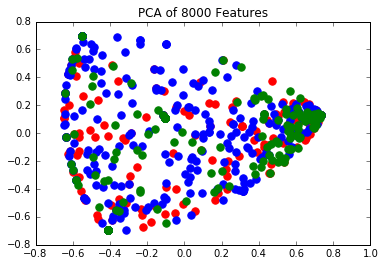

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt

lw = 2

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(_df["x"], _df["y"], c=_df["year"], s=55, lw=lw)
gothic = _df.loc[_df['final_genre'] == "gothic"]
scifi = _df.loc[_df['final_genre'] == "scifi"]
crime = _df.loc[_df['final_genre'] == "crime"]


ax1.scatter(scifi["x"], scifi["y"], color="red", s=55)
ax1.scatter(crime["x"], crime["y"], color="blue", s=55)
ax1.scatter(gothic["x"], gothic["y"], color="green", s=55)

plt.title('PCA of 8000 Features')
plt.show()



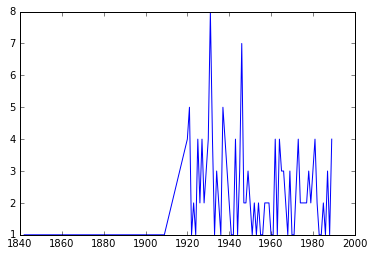

In [142]:
one_group = _df.loc[_df['group_label'] == 0]
from collections import Counter
a = Counter(one_group["year"])
b = sorted(a.items())
plt.plot([i[0] for i in b], [i[1] for i in b])
plt.show()

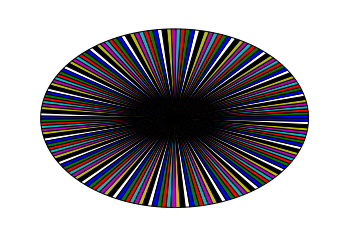

In [121]:
plt.pie(one_group["year"])
plt.show()